In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import numpy as np
from astropy.stats import mad_std, SigmaClip, sigma_clipped_stats
from astropy.nddata import CCDData
import pandas as pd
from photutils.detection import DAOStarFinder
from photutils import *
from astropy.io import fits
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
from astropy.table import Table
from astropy import units as u
import sys
sys.path.insert(0, '/Users/josue/kosmos/')
import warnings
warnings.filterwarnings('ignore')
import kosmos

In [2]:
# Creats a directory array
def dir_array(D, j):
    i = pd.read_table(D + j, names=['impath'])
    k = D + i['impath'].values
    #print(k)
    return k

# SS Cyg in the i filter
def reduce(dir_array, bias, flat):
    sciimg_array = []
    for i in dir_array:
        sci = i
        sciimg = kosmos.proc(sci, bias=bias, ilum=None, flat=flat, trim=None)
        sciimg_array.append(sciimg)
    return sciimg_array

# gets header 
def get_header(dir_arrray, HEADER):
    j = []
    for i in dir_arrray:
        hdu_list = fits.open(i)
        a = hdu_list[0].header[HEADER]
        j.append(a)
    return j

# Magnitude function 
def makemag(flux,exptime,C):
    m = C - 2.5 * np.log(np.abs(flux / exptime))
    return m

In [3]:
# First night
dir = 'C:/Users/josue/Work-space/Project 2/Data/07.28.2022/'

# Master bias
biasfiles_1 = pd.read_table(dir + 'bias_28.txt', names=['impath'])
biasfiles1 = dir + biasfiles_1['impath'].values
bias = kosmos.biascombine(biasfiles1) 

# Master flats
i_flats = dir_array(dir, "flats_i.txt")
flat_i = kosmos.flatcombine(i_flats, bias=bias, trim=None, illumcor=False)

# Reduced object SS Cyg
ss_cyg1 = dir_array(dir, "ss_cyg.txt")
SS_Cyg1 = reduce(ss_cyg1, bias, flat_i)

# SS Cyg not reduced
ss_cyg_r = CCDData.read(ss_cyg1[5])

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

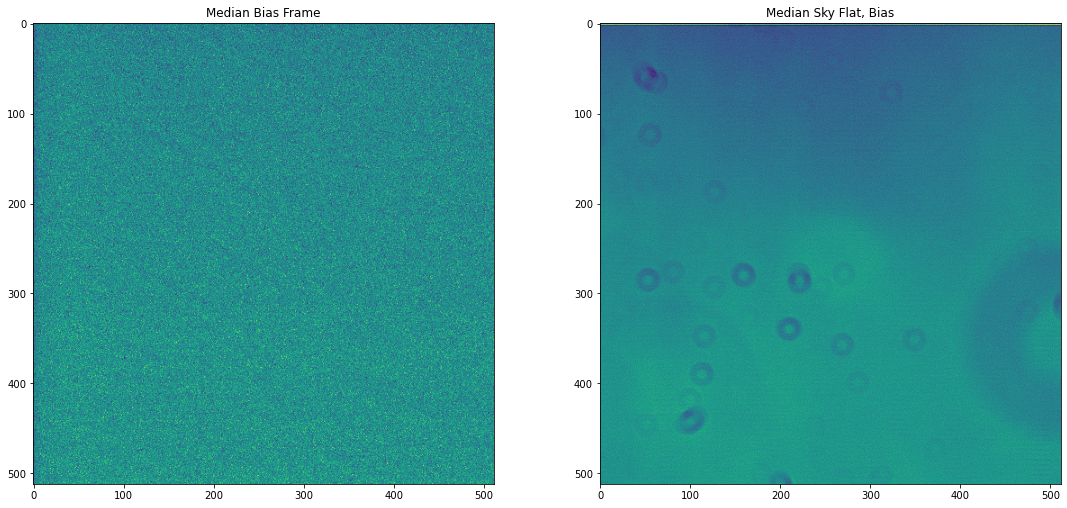

In [4]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(15, 15)
fig.tight_layout(w_pad=7.5, h_pad=5.5)

# Bias 
ax[0].imshow(bias)
ax[0].title.set_fontsize(20)
ax[0].set_title('Median Bias Frame');

ax[1].imshow(flat_i)
ax[1].title.set_fontsize(20)
ax[1].set_title('Median Sky Flat, Bias');

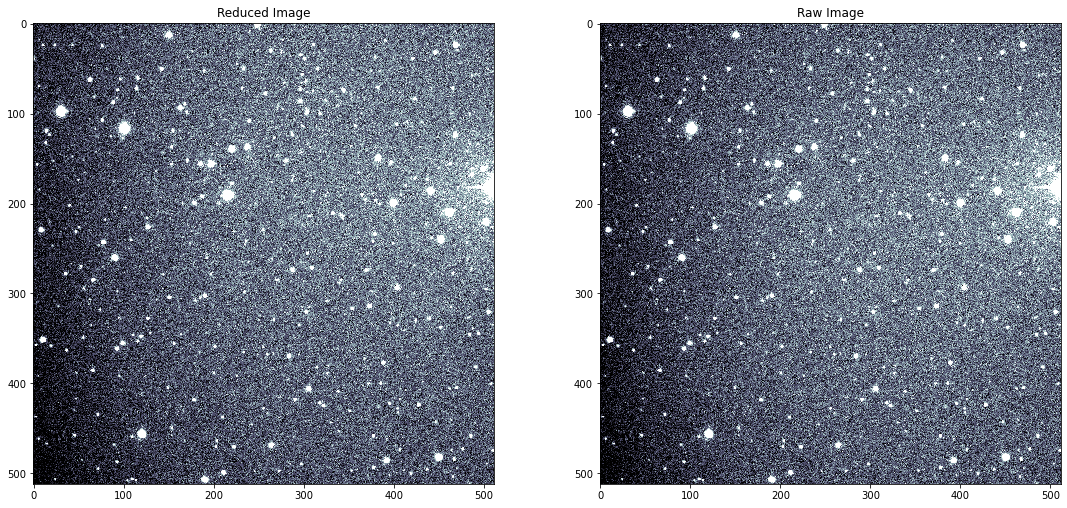

In [5]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(15, 15)
fig.tight_layout(w_pad=7.5, h_pad=5.5)

# Bias 
ax[0].imshow(SS_Cyg1[5], vmin=np.percentile(SS_Cyg1[5], 5), 
             vmax=np.percentile(SS_Cyg1[5], 98), cmap='bone', interpolation='nearest');
ax[0].title.set_fontsize(20)
ax[0].set_title('Reduced Image');

ax[1].imshow(ss_cyg_r, vmin=np.percentile(ss_cyg_r, 5), 
             vmax=np.percentile(ss_cyg_r, 98), cmap='bone', interpolation='nearest');
ax[1].title.set_fontsize(20)
ax[1].set_title('Raw Image');


## Finding Flux

In [6]:
m = 5
mean, median, std = sigma_clipped_stats(SS_Cyg1[m], sigma=3.0)
step = SS_Cyg1[m].data
sciimg_data = np.ma.getdata(step)

[1408.74380029 2076.18353676 2343.90891914 2189.1172295 ]
[-1407.71973899 -2066.79967541 -2342.16281983 -2181.75651373]


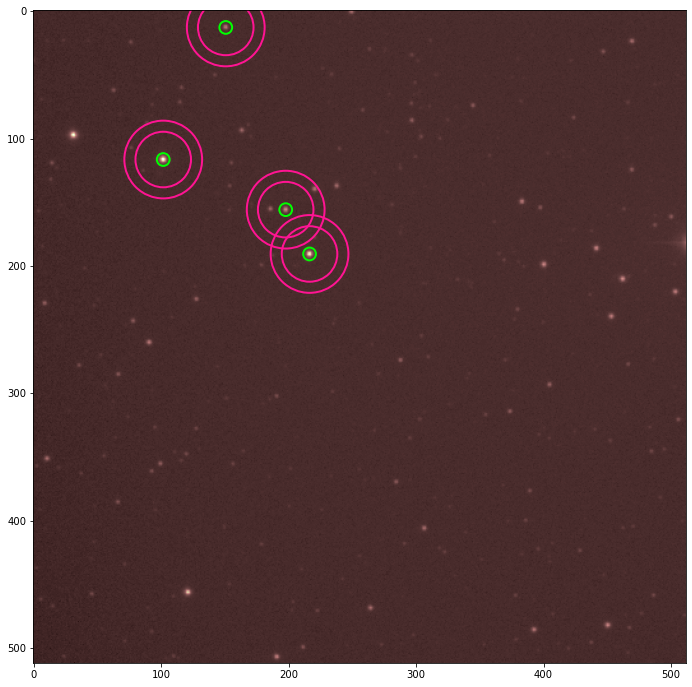

In [11]:
dao = DAOStarFinder(fwhm=2.18, threshold=500)
sources = dao(sciimg_data - median)
mask = sources['xcentroid'] < 300
sources = sources[mask]
mask2 = sources['xcentroid'] > 100
sources = sources[mask2]
mask3 = sources['ycentroid'] < 250
sources = sources[mask3]

positions = []

for i, j in zip(sources['xcentroid'], sources['ycentroid']):
    positions.append((i,j));

apertures = CircularAperture(positions, r=5)
norm = ImageNormalize(stretch=SqrtStretch())

# wanted star is at xcent (208.95246610163315, 171.59263980420403)
annulus = CircularAnnulus(positions,r_in = 21.8,r_out = 30.52)
plt.figure(figsize=(12,12))
annulus.plot(color='deeppink', linewidth=2)
apertures.plot(color='lime',linewidth=2, label = 'Best')
plt.imshow(sciimg_data, norm=norm, cmap='pink');
total_sky = aperture_photometry(sciimg_data,annulus)['aperture_sum']
avg_sky = total_sky / annulus.area
sky = avg_sky * apertures.area
print(sky.data)
fluxes = sources['flux'].data - sky.data
print(fluxes)